### Carregamento das Bibliotecas e dos Datasets

In [14]:
#Célula 1: imports e carregamento dos datasets

from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from textblob import TextBlob
from transformers import pipeline


df_items = pd.read_csv(r"archive\olist_order_items_dataset.csv")
df_reviews = pd.read_csv(r"archive\olist_order_reviews_dataset.csv")
df_orders = pd.read_csv(r"archive\olist_orders_dataset.csv")
df_products = pd.read_csv(r"archive\olist_products_dataset.csv")
df_categorytranslation = pd.read_csv(r"archive\product_category_name_translation.csv")
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Pré-processamento de dados usando BERT
Estão presentes nesse trecho duas funções: uma para retornar a pontuação baseada no comentário feita pelo modelo; a outra para classificar o sentimento
entre positivo, negativo e neutro baseado nesse escore.

In [15]:
# Célula 2: Estabelecendo funções para obter um sentimento a partir do score e obter um sentimento a partir do comentário
# carrega o modelo pré-treinado para análise de sentimento em português
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def retornarestrela_bert(texto):
    if pd.isnull(texto) or len(texto.strip()) == 0: #verifica se o texto está vazio se remover os espaços em branco e, se estiver, já fica estabelecido como neutro
        return "neutro"

    resultado = sentiment_model(texto[:512])[0] #limita pra 512 tokens

    estrela = int(resultado["label"][0]) #extrai da analise do comentario a 'estrela' da review
    return estrela

def classificarsentimento(comment_score):
    if isinstance(comment_score, str) and comment_score == "neutro":
        return "Neutro"

    if isinstance(comment_score, int):
        estrela = comment_score
        if estrela <= 2:
            return "Negativo"
        elif estrela == 3:
            return "Neutro"
        else: # 4 or 5
            return "Positivo"
    return "Neutro"





Device set to use cpu


### Merge dos dados usando order_id, product_id e product_category_name
### Categorizar sentimentos e notas:
Foi criada a categoria comment_score:
Notas de 1 a 5 (com base no modelo BERT)
Além disso, foi criada também sentimento_comentario usando a função do módulo anterior.


In [16]:
#Célula 4: Mesclando os dataframes e criando novas colunas

df1 = pd.merge(df_items, df_reviews, on='order_id', how='inner')
df2 = pd.merge(df1, df_orders, on='order_id', how='inner')
df3 = pd.merge(df2, df_products, on='product_id', how='inner')
df_final = pd.merge(df3, df_categorytranslation, on='product_category_name', how='inner')


# delimitei a amostra para 1000 avaliações com comentários
df_final_amostra = df_final[df_final['review_comment_message'].notnull()].sample(1000, random_state=42)

# aplica a função classificar_sentimento_bert apenas na amostra
df_final_amostra['comment_score'] = df_final_amostra['review_comment_message'].apply(retornarestrela_bert)
df_final_amostra['sentimento_comentario'] = df_final_amostra['comment_score'].apply(classificarsentimento)
df_final_amostra['sentimento_nota'] = df_final_amostra['review_score'].apply(classificarsentimento)

Acurácia de compatibilidade entre a análise usando o sentimento do comentário e o sentimento avaliado pela nota: 73.20%


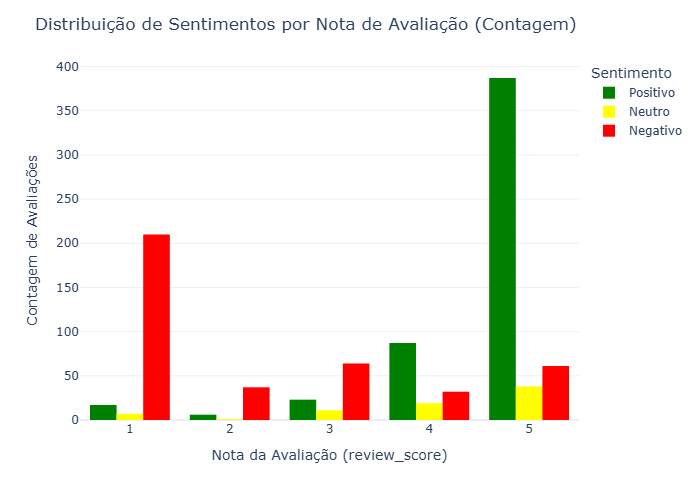

In [17]:
#Célula 5: Analisando a acurácia da análise

fig = px.histogram(
    df_final_amostra,
    x="review_score",
    color="sentimento_comentario",
    color_discrete_map={
        'Positivo': 'green',
        'Neutro': 'yellow',
        'Negativo': 'red',
    },
    barmode='group',
    category_orders={
        "sentimento_comentario": ['Positivo', 'Neutro', 'Negativo']  # ordem desejada das cores
    }
)

fig.update_layout(
    title='Distribuição de Sentimentos por Nota de Avaliação (Contagem)',
    xaxis_title='Nota da Avaliação (review_score)',
    yaxis_title='Contagem de Avaliações',
    legend_title='Sentimento',
    bargap=0.2,
    template='plotly_white'
)

fig.write_image("figure.png")

acuracia = (df_final_amostra['sentimento_comentario'] == df_final_amostra['sentimento_nota']).mean() * 100
print(f"Acurácia de compatibilidade entre a análise usando o sentimento do comentário e o sentimento avaliado pela nota: {acuracia:.2f}%")
Image("figure.png")

### Calculo da proporção de avaliações baixas (notas 1 e 2) e altas (notas 4 e 5) para cada categoria de produto:
Primeiro, conta o total de avaliações por categoria.
Depois, filtra as avaliações baixas e altas, calcula suas proporções em relação ao total.
Por fim, cria um DataFrame com essas proporções e filtra apenas as categorias com pelo menos 30 avaliações.

In [18]:
#Célula 6: Fazendo um dataframe da proporção do teor das avaliações

# # contagem total por categoria
total_por_categoria = df_final_amostra.groupby('product_category_name')['review_score'].count()

# contagens separadas por tipo de nota
contagem_baixas = df_final_amostra[df_final_amostra['review_score'].isin([1, 2])] \
    .groupby('product_category_name')['review_score'].count()


contagem_altas = df_final_amostra[df_final_amostra['review_score'].isin([4, 5])] \
    .groupby('product_category_name')['review_score'].count()

proporcao_baixas = (contagem_baixas / total_por_categoria).fillna(0)
proporcao_altas = (contagem_altas / total_por_categoria).fillna(0)

# dataframe das proporçoes
df_proporcao = pd.DataFrame({
    'proporcao_baixas': proporcao_baixas,
    'proporcao_altas': proporcao_altas
}).agg(list).reset_index()

df_proporcao.head(10)
total_comentarios = df_final_amostra.groupby('product_category_name')['review_score'].count()
categorias_filtradas = total_comentarios[total_comentarios >= 30].index # filtra as categorias com um piso de quantidade de comentarios em 30

# filtrar df_proporcao com essas categorias
df_proporcao_filtrado = df_proporcao[df_proporcao['product_category_name'].isin(categorias_filtradas)]

In [19]:
#Célula 7: Fazendo um ranking das categorias melhores avaliadas dentro do filtro considerando a proporção de notas positivas.
ranking_filtrado_altas = df_proporcao_filtrado.sort_values(by='proporcao_altas', ascending=False).reset_index(drop=True)
ranking_filtrado_altas[['product_category_name', 'proporcao_altas']].head(10)

,product_category_name,proporcao_altas
0,utilidades_domesticas,0.703125
1,cama_mesa_banho,0.681034
2,telefonia,0.680851
3,ferramentas_jardim,0.666667
4,brinquedos,0.642857
5,esporte_lazer,0.621622
6,relogios_presentes,0.619048
7,cool_stuff,0.612903
8,beleza_saude,0.594203
9,moveis_decoracao,0.555556


C:\Users\diego\AppData\Local\Temp\ipykernel_8604\636476528.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



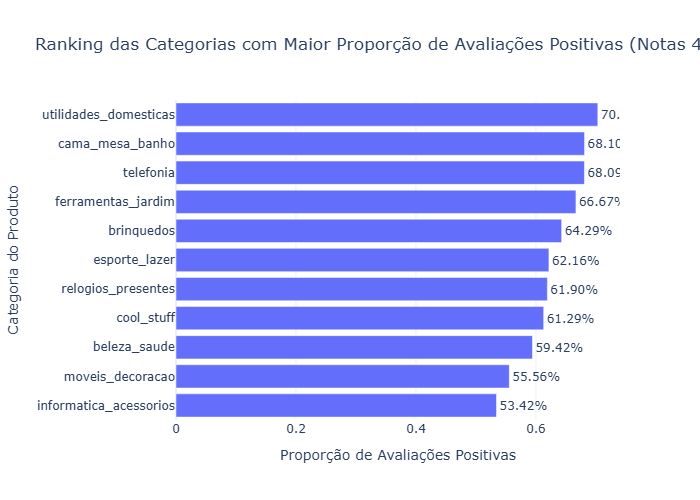

In [20]:
#Célula 8: Gráfico de barras do novo dataframe
df_proporcao_filtrado['proporcao_altas_val'] = df_proporcao_filtrado['proporcao_altas'].apply(lambda x: x[0] if isinstance(x, list) else x)

df_proporcao_filtrado = df_proporcao_filtrado.sort_values(by='proporcao_altas_val', ascending=False)

# plotar gráfico de barras horizontal
grafico = px.bar(
    df_proporcao_filtrado,
    x='proporcao_altas_val',
    y='product_category_name',
    orientation='h',
    labels={
        'proporcao_altas_val': 'Proporção de Avaliações Positivas',
        'product_category_name': 'Categoria do Produto'
    },
    title='Ranking das Categorias com Maior Proporção de Avaliações Positivas (Notas 4 e 5)',
    text=df_proporcao_filtrado['proporcao_altas_val'].apply(lambda x: f"{x:.2%}")
)

grafico.update_traces(textposition='outside')
grafico.update_layout(yaxis={'categoryorder':'total ascending'}, template='plotly_white', margin=dict(l=150))
grafico.write_image("grafico.png")
Image("grafico.png")

## Categorias de maior satisfação:
Alta Satisfação em Categorias Essenciais
Utilidades domésticas (70,31%), cama, mesa e banho (68,10%) e telefonia (68,09%) lideram o ranking.
Essas categorias estão ligadas ao uso cotidiano e conforto, sugerindo que os produtos nelas oferecem uma boa relação custo-benefício e atendem às expectativas dos consumidores.

Agora, é feito o ranking das categorias filtradas com pior avaliação com base na proporção.

In [21]:
#Célula 9: Ranking das piores categorias com mais avaliações baixas
# Garante que a coluna proporcao_baixas_val contenha valores escalares
df_proporcao_filtrado['proporcao_baixas_val'] = df_proporcao_filtrado['proporcao_baixas'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Ordena pelo maior valor de proporcao_baixas (piores categorias nesse critério)
ranking_filtrado_baixas = df_proporcao_filtrado.sort_values(by='proporcao_baixas_val', ascending=False).reset_index(drop=True)

# Mostra as 10 piores categorias com mais avaliações baixas
ranking_filtrado_baixas[['product_category_name', 'proporcao_baixas_val']].head(10)


,product_category_name,proporcao_baixas_val
0,informatica_acessorios,0.328767
1,beleza_saude,0.318841
2,telefonia,0.297872
3,moveis_decoracao,0.291667
4,ferramentas_jardim,0.288889
5,brinquedos,0.261905
6,cool_stuff,0.258065
7,esporte_lazer,0.243243
8,utilidades_domesticas,0.234375
9,cama_mesa_banho,0.232759


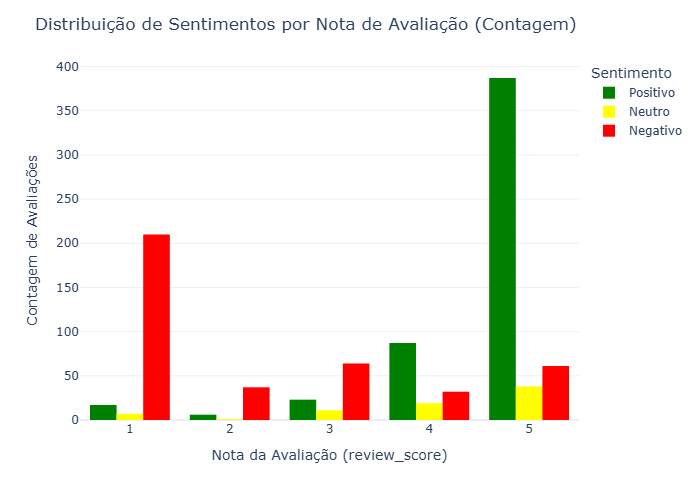

In [22]:
#Célula 10: Gráfico do ranking das piores categorias
# Garante que os valores estejam como escalares e não listas
df_proporcao_filtrado['proporcao_baixas_val'] = df_proporcao_filtrado['proporcao_baixas'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Ordena da maior para a menor proporção de avaliações negativas
df_proporcao_filtrado = df_proporcao_filtrado.sort_values(by='proporcao_baixas_val', ascending=False)

# Gera gráfico com Plotly exibindo as categorias mais mal avaliadas no topo
fig = px.bar(
    df_proporcao_filtrado,
    x='proporcao_baixas_val',
    y='product_category_name',
    orientation='h',
    labels={
        'proporcao_baixas_val': 'Proporção de Avaliações Baixas',
        'product_category_name': 'Categoria do Produto'
    },
    title='Ranking das Categorias com Maior Proporção de Avaliações Baixas (Notas 1 e 2)',
    text=df_proporcao_filtrado['proporcao_baixas_val'].apply(lambda x: f"{x:.2%}")
)

fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},  # <- isso faz o gráfico mostrar as piores no topo
    template='plotly_white',
    margin=dict(l=150)
)

fig.write_image("fig.png")
Image("figure.png")


### Categorias de menor satisfação:
Informática e Acessórios (32,88%), Beleza e Saúde (31,88%) e Telefonia (29,79%) são as três categorias com maior proporção de avaliações negativas.
Isso pode indicar problemas recorrentes como produtos danificados, entregas fora do prazo, expectativa vs. realidade, ou até suporte técnico insatisfatório.

### Insights interessantes:
1. Telefonia, Ferramentas e Jardim, Brinquedos e Beleza e saúde aparecem em ambos os rankings - o que isso significa?
Significa que são muito polarizadas, ou seja, por motivos como qualidade extremamente variável entre marcas diferentes, ou até mesmo expectativas desalinhadas com o produto entregue.

2. Informática e Acessórios possui a maior proporção de avaliações negativas e não tem grande destaque nas avaliações positivas. No cruzamento entre as 2 tabelas, essa é a categoria mais crítica em termos de satisfação geral.
Pode se supor que os motivos possam ser falhas recorrentes no funcionamento e a falta de suporte técnico para solucionar essas falhas.

3. Utilidades Domésticas tem a maior proporção de avaliações positivas (70,31%), sem aparecer entre as maiores proporções de negativas. Pode se concluir disso que os produtos dessa categoria estão entregando uma boa experiência consistente.

In [23]:
#Célula 11: Criando novas funções de análises combinando as anteriores

def classificar_sentimento_pela_nota(nota):
    if nota in [1, 2]:
        return "Negativo"
    elif nota == 3:
        return "Neutro"
    elif nota in [4, 5]:
        return "Positivo"
    return None
df_final_amostra['sentimento_nota'] = df_final_amostra['review_score'].apply(classificar_sentimento_pela_nota)

def analise_combinada1(df):
    score = df['review_score']
    sentimento_texto_estimado = df['sentimento_comentario']

    if score >= 4 or sentimento_texto_estimado == "positivo":
        return "Positivo"
    elif score <= 2 or sentimento_texto_estimado == "negativo":
        return "Negativo"
    else:
        return "Neutro"

df_final_amostra['analise_combinada1'] = df_final_amostra.apply(analise_combinada1, axis=1)

df_comparacao1 = df_final_amostra[
    ['product_category_name', 'review_score','sentimento_nota', 'review_comment_message', 'sentimento_comentario',  'analise_combinada1']
].agg(list).reset_index()

df_comparacao1.head(10)

,index,product_category_name,review_score,sentimento_nota,review_comment_message,sentimento_comentario,analise_combinada1
0,84629,bebes,1,Negativo,"A rede é inadequada pra criança, pois o risco ...",Negativo,Negativo
1,54369,moveis_sala,5,Positivo,Produto de ótima qualidade e entregue muito an...,Positivo,Positivo
2,82455,eletronicos,2,Negativo,Fiz uma compra em um so pedido de uma TV e um ...,Negativo,Negativo
3,108948,ferramentas_jardim,5,Positivo,Melhor city para comprar online maravilhoso,Positivo,Positivo
4,31380,moveis_decoracao,5,Positivo,Chegou dentro do prazo. Adorei as peças!,Positivo,Positivo
5,34443,brinquedos,1,Negativo,Só foi entregue o elefantinho. O dois ursinhos...,Negativo,Negativo
6,86685,informatica_acessorios,3,Neutro,Entrega dentro do prazo previsto. Satisfeito.,Positivo,Neutro
7,14982,beleza_saude,5,Positivo,Muito bom mesmo!!!,Positivo,Positivo
8,34577,cama_mesa_banho,5,Positivo,Tudo perfeito... Adorei,Positivo,Positivo
9,102904,pet_shop,5,Positivo,Ótima compra! Produto excelente! Recomendo,Positivo,Positivo


In [24]:
acuracia1 = (df_final_amostra['sentimento_comentario'] == df_final_amostra['sentimento_nota']).mean() * 100
print(f"Acurácia de compatibilidade entre a análise usando score médio e o score da avaliação: {acuracia1:.2f}%")

Acurácia de compatibilidade entre a análise usando score médio e o score da avaliação: 73.20%


1. Função que calcula uma média entre a nota da avaliação e a nota do comentário, para definir outro sentimento combinado

2. Aplicando a função para criar a coluna 'analise_combinada2' no DataFrame

3. Agrupa os dados selecionados em listas por categoria e reseta o índice

4. Exibe as 10 primeiras linhas do DataFrame agrupado


In [25]:
def analise_combinada2(df):
    score = df['review_score']
    scorecomment = df['comment_score']
    scoremedio = (score + scorecomment) / 2

    if scoremedio >= 3.5:
        return "Positivo"
    elif scoremedio <= 2.5:
        return "Negativo"
    else:
        return "Neutro"


df_final_amostra['analise_combinada2'] = df_final_amostra.apply(analise_combinada2, axis=1)

# Agrupa e conta quantas linhas tem em cada grupo
df_comparacao2 = df_final_amostra[
    ['product_category_name', 'review_score','sentimento_nota', 'review_comment_message', 'sentimento_comentario',  'analise_combinada2']
].agg(list).reset_index()

df_comparacao2.head(10)

,index,product_category_name,review_score,sentimento_nota,review_comment_message,sentimento_comentario,analise_combinada2
0,84629,bebes,1,Negativo,"A rede é inadequada pra criança, pois o risco ...",Negativo,Negativo
1,54369,moveis_sala,5,Positivo,Produto de ótima qualidade e entregue muito an...,Positivo,Positivo
2,82455,eletronicos,2,Negativo,Fiz uma compra em um so pedido de uma TV e um ...,Negativo,Negativo
3,108948,ferramentas_jardim,5,Positivo,Melhor city para comprar online maravilhoso,Positivo,Positivo
4,31380,moveis_decoracao,5,Positivo,Chegou dentro do prazo. Adorei as peças!,Positivo,Positivo
5,34443,brinquedos,1,Negativo,Só foi entregue o elefantinho. O dois ursinhos...,Negativo,Negativo
6,86685,informatica_acessorios,3,Neutro,Entrega dentro do prazo previsto. Satisfeito.,Positivo,Positivo
7,14982,beleza_saude,5,Positivo,Muito bom mesmo!!!,Positivo,Positivo
8,34577,cama_mesa_banho,5,Positivo,Tudo perfeito... Adorei,Positivo,Positivo
9,102904,pet_shop,5,Positivo,Ótima compra! Produto excelente! Recomendo,Positivo,Positivo


In [26]:
acuracia2 = (df_final_amostra['analise_combinada2'] == df_final_amostra['sentimento_nota']).mean() * 100
print(f"Acurácia de compatibilidade entre a análise usando score médio (última análise) e o score da avaliação: {acuracia2:.2f}%")

Acurácia de compatibilidade entre a análise usando score médio (última análise) e o score da avaliação: 81.80%
